In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from Bayesian2 import BayesianLinearRegression

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYield,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-05-28,a624fb9a,SE-064c0cec-1189,3242,02 SLB,8.0,3.0,2022-2,15.22,NaN,...,1.135858,NaN,1.820438,0,0,0,0,9.912500,50.478673,NaN
1,2022-05-29,a624fb9a,SE-064c0cec-1189,3243,02 SLB,8.0,4.0,2022-2,18.96,15.22,...,1.091521,0.215311,1.589745,0,0,0,0,10.066667,53.841648,NaN
2,2022-05-30,a624fb9a,SE-064c0cec-1189,3244,02 SLB,8.0,5.0,2022-2,22.64,18.96,...,1.091326,0.177389,1.894598,0,1,0,0,10.466667,52.935959,NaN
3,2022-05-31,a624fb9a,SE-064c0cec-1189,3245,02 SLB,8.0,6.0,2022-2,26.49,22.64,...,1.121861,0.163049,2.877443,0,0,0,0,11.183333,52.872112,NaN
4,2022-06-01,a624fb9a,SE-064c0cec-1189,3246,02 SLB,8.0,7.0,2022-3,33.61,26.49,...,1.290389,0.273358,7.563598,0,1,0,0,12.704167,56.056547,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576066,2024-08-09,f454e660,SE-f454e660-810,1020,99 Korsning/obestämbar ras,1.0,365.0,2024-3,37.53,31.36,...,1.027417,0.168909,1.001508,1,1,0,0,18.650000,62.298109,-0.049177
576067,2024-08-10,f454e660,SE-f454e660-810,1021,99 Korsning/obestämbar ras,1.0,365.0,2024-3,36.48,37.53,...,0.998673,-0.028745,-0.048492,1,1,0,0,18.308333,54.687773,-0.049177
576068,2024-08-11,f454e660,SE-f454e660-810,1022,99 Korsning/obestämbar ras,1.0,365.0,2024-3,34.76,36.48,...,0.951586,-0.047087,-1.768492,1,1,0,0,17.841667,55.974084,-0.049177
576069,2024-08-12,f454e660,SE-f454e660-810,1023,99 Korsning/obestämbar ras,1.0,365.0,2024-3,38.06,34.76,...,1.041926,0.090340,1.531508,1,1,0,0,17.516667,60.115007,-0.049177


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.961265,1.007475
1,2022-2,0.963891,1.008171
2,2022-3,0.961517,1.007748
3,2022-4,0.961861,1.008555
4,2023-1,0.958998,1.008404
5,2023-2,0.956737,1.007762
6,2023-3,0.960996,1.008008
7,2023-4,0.961912,1.007833
8,2024-1,0.964989,1.007607
9,2024-2,0.960734,1.007569


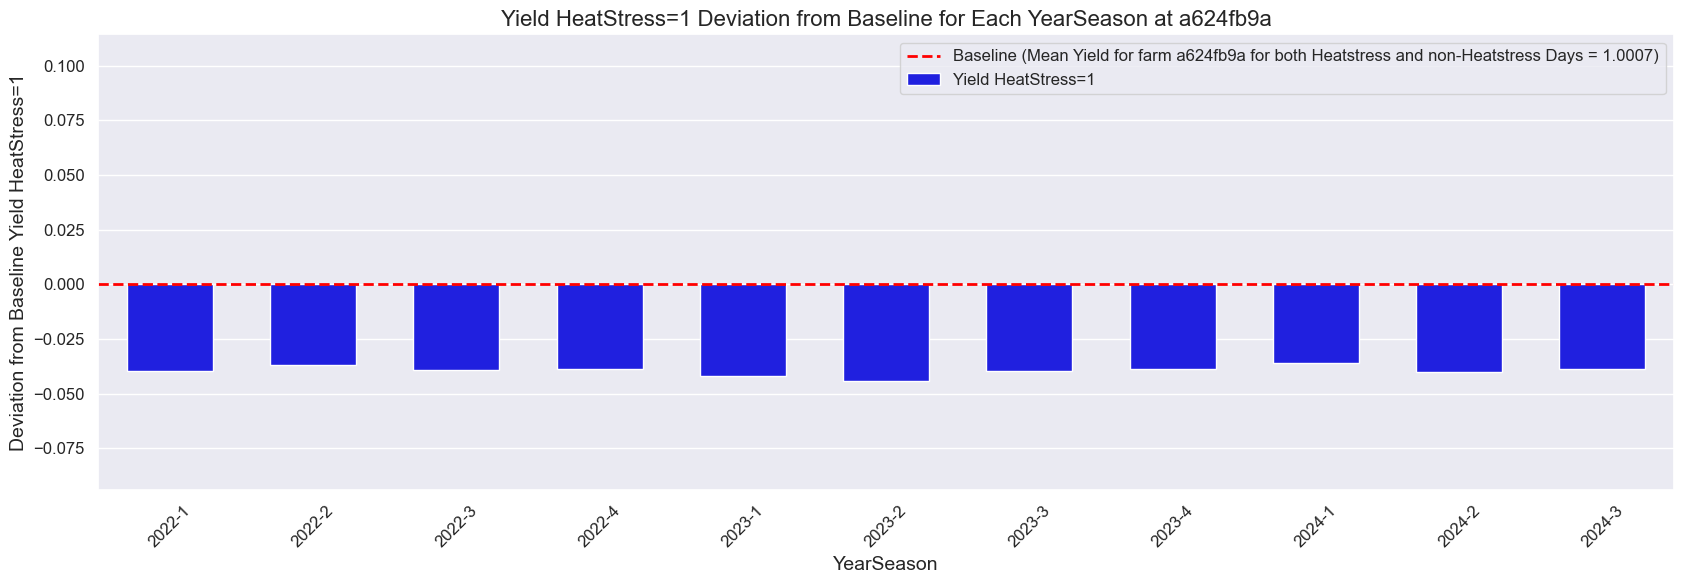

In [4]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.05, max(results_df['Deviation from Baseline HeatStress=1']) + 0.15)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

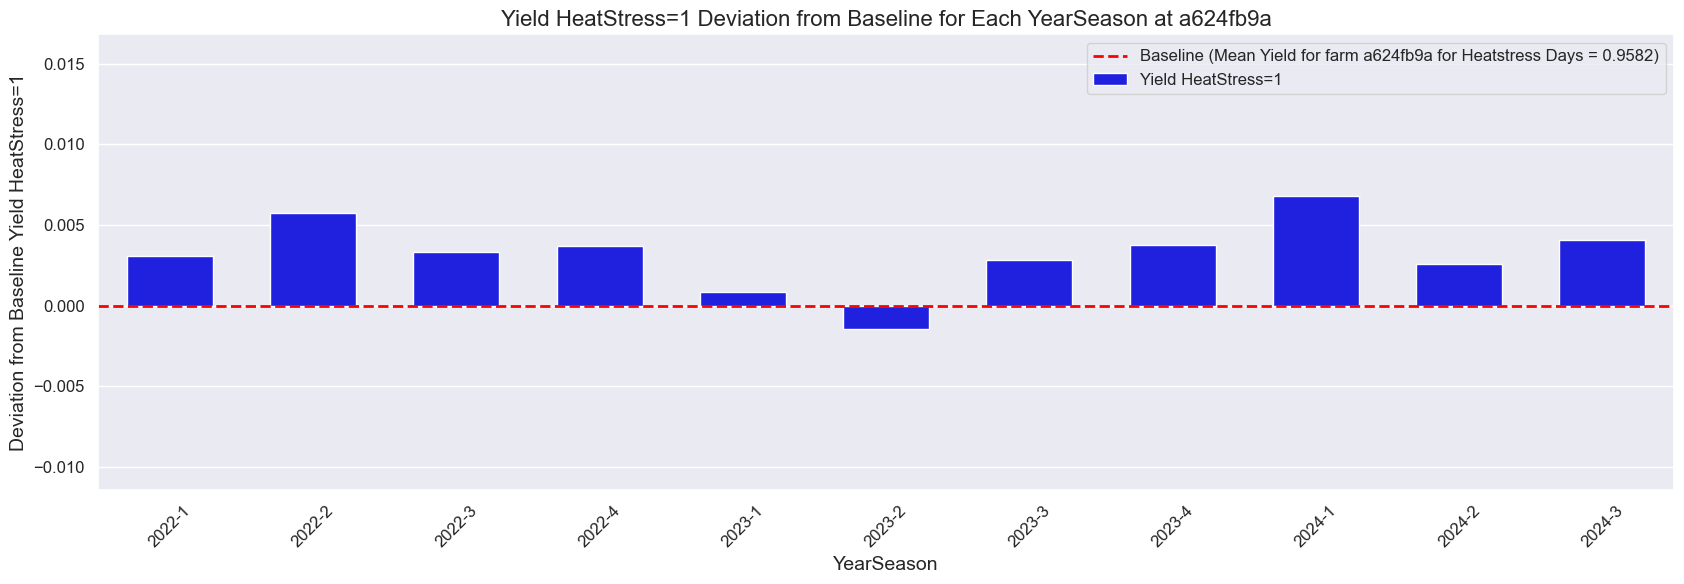

In [5]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm 5c06d92d

In [6]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.874310,1.005543
1,2022-2,0.880456,1.005697
2,2022-3,0.871939,1.005597
3,2022-4,0.871975,1.005542
4,2023-1,0.872914,1.005556
5,2023-2,0.860960,1.005801
6,2023-3,0.864955,1.005785
7,2023-4,0.869428,1.005635
8,2024-1,0.876265,1.005401
9,2024-2,0.874921,1.005236


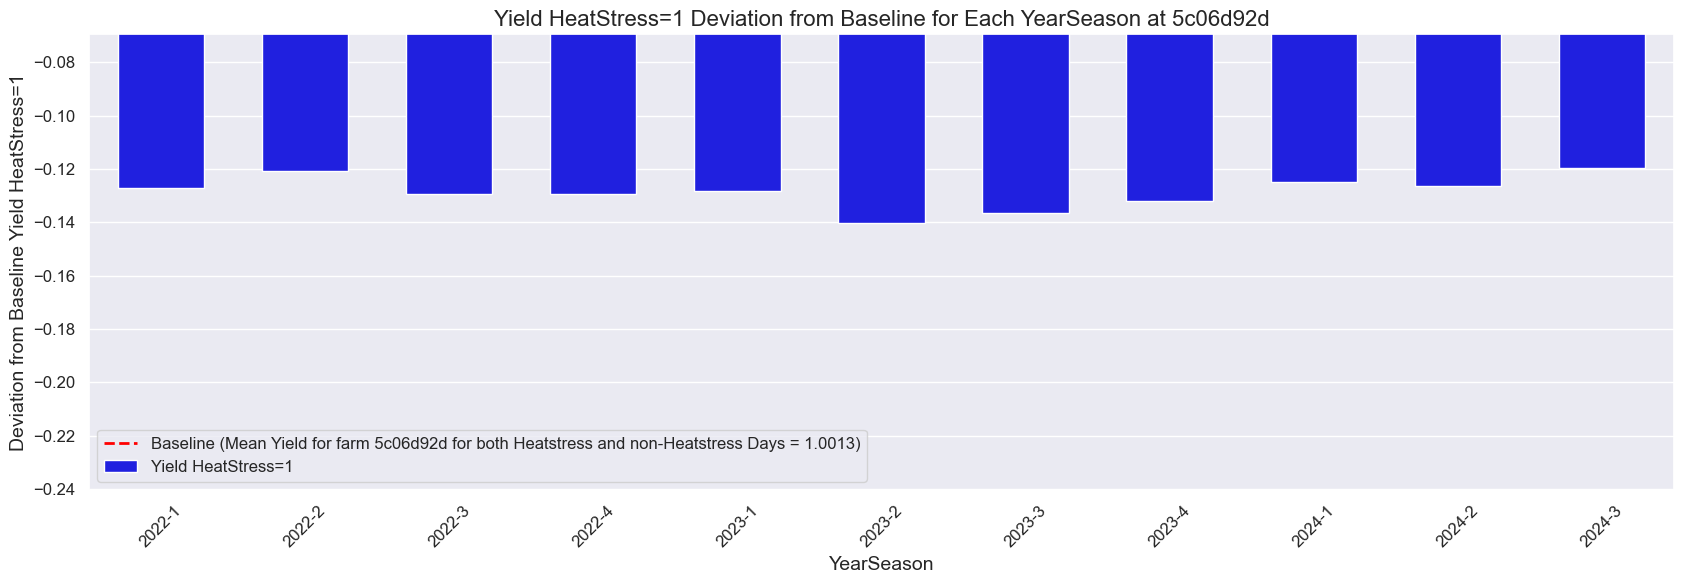

In [7]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.1, max(results_df['Deviation from Baseline HeatStress=1']) + 0.05)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

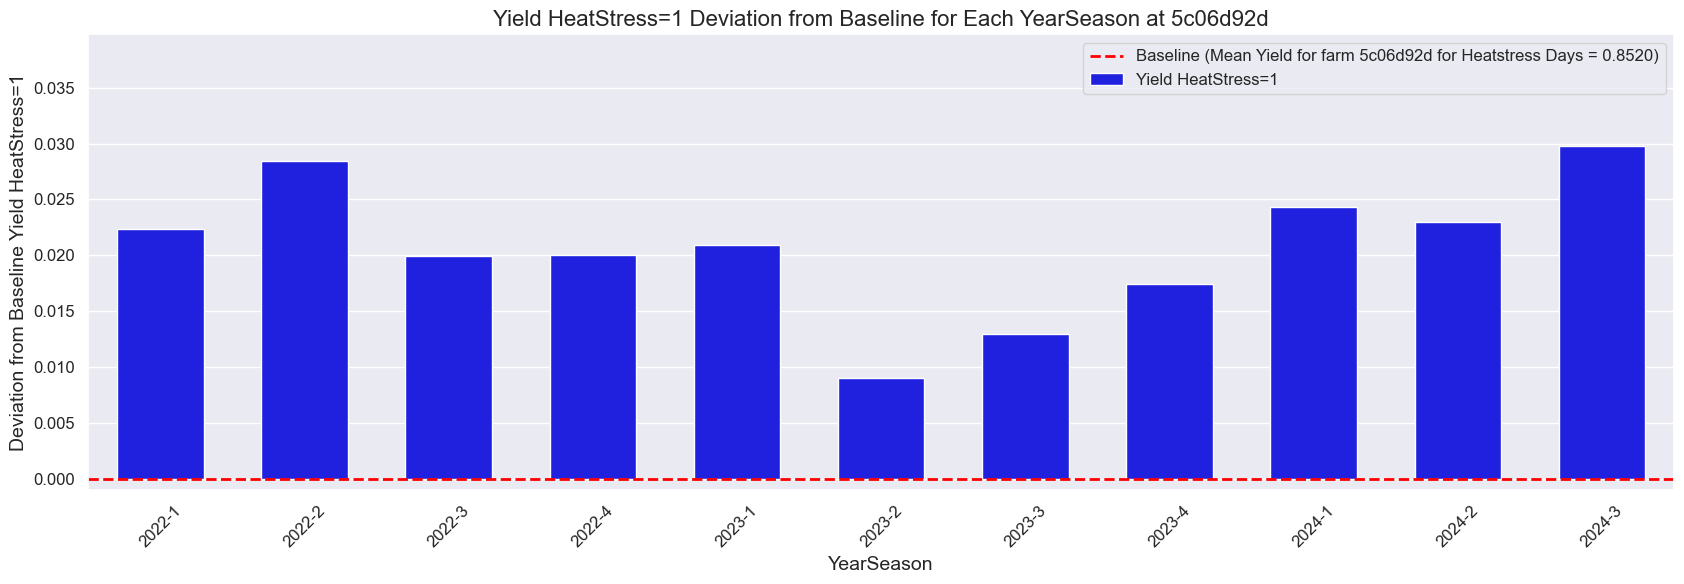

In [8]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm 752efd72

In [9]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.995019,1.006405
1,2022-2,1.014517,1.006765
2,2022-3,1.002368,1.006468
3,2022-4,0.997904,1.006577
4,2023-1,0.973780,1.006783
5,2023-2,0.975697,1.006751
6,2023-3,0.966240,1.006826
7,2023-4,0.961054,1.006807
8,2024-1,0.956734,1.006723
9,2024-2,0.954862,1.006649


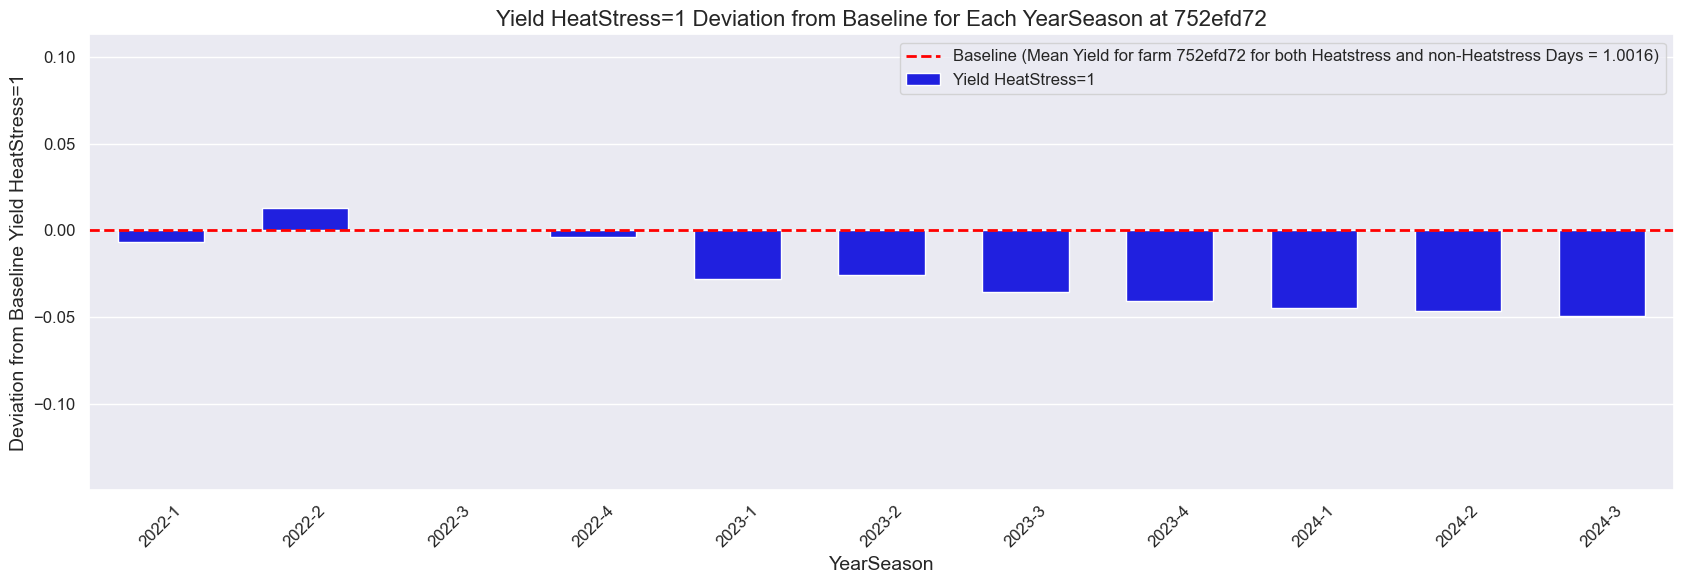

In [10]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.1, max(results_df['Deviation from Baseline HeatStress=1']) + 0.1)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

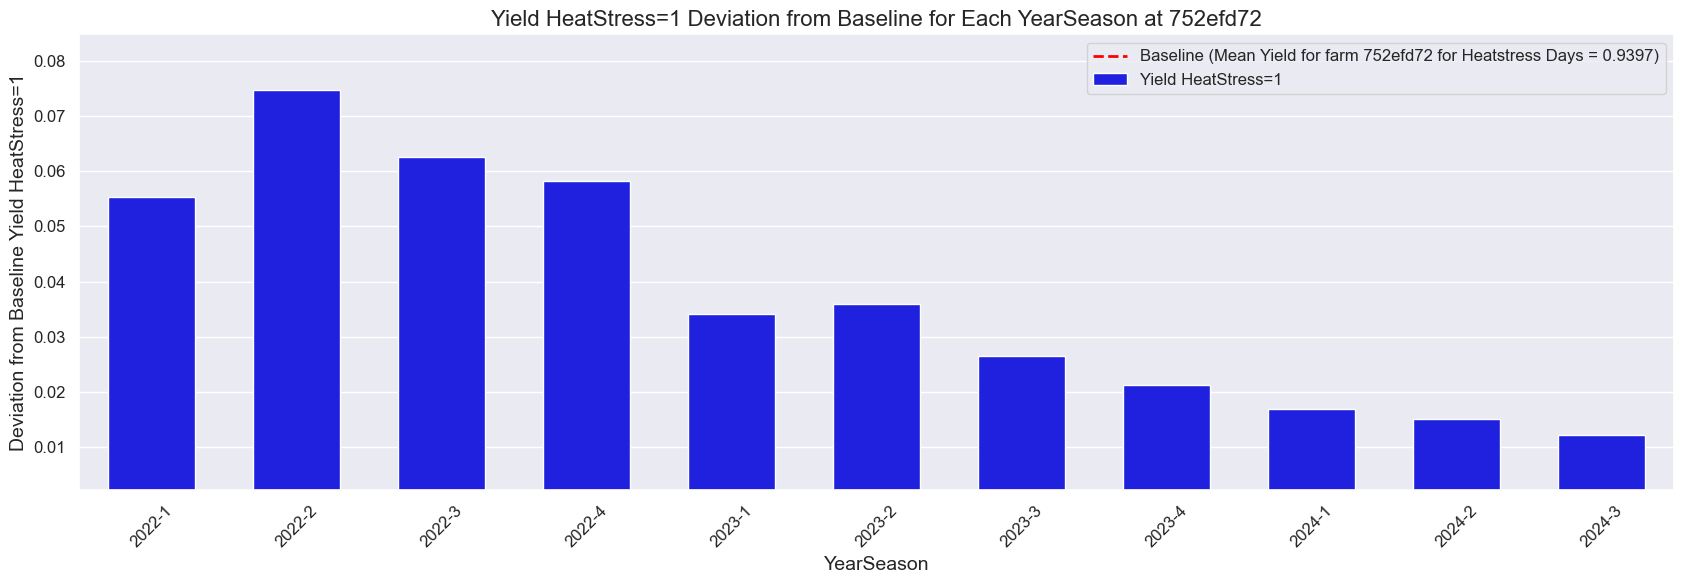

In [11]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm f454e660

In [12]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.961669,1.008115
1,2022-2,0.952088,1.008124
2,2022-3,0.963212,1.006802
3,2022-4,0.957563,1.007691
4,2023-1,0.967146,1.009731
5,2023-2,0.963078,1.009454
6,2023-3,0.972606,1.009699
7,2023-4,0.967074,1.010259
8,2024-1,0.966884,1.010901
9,2024-2,0.967437,1.010488


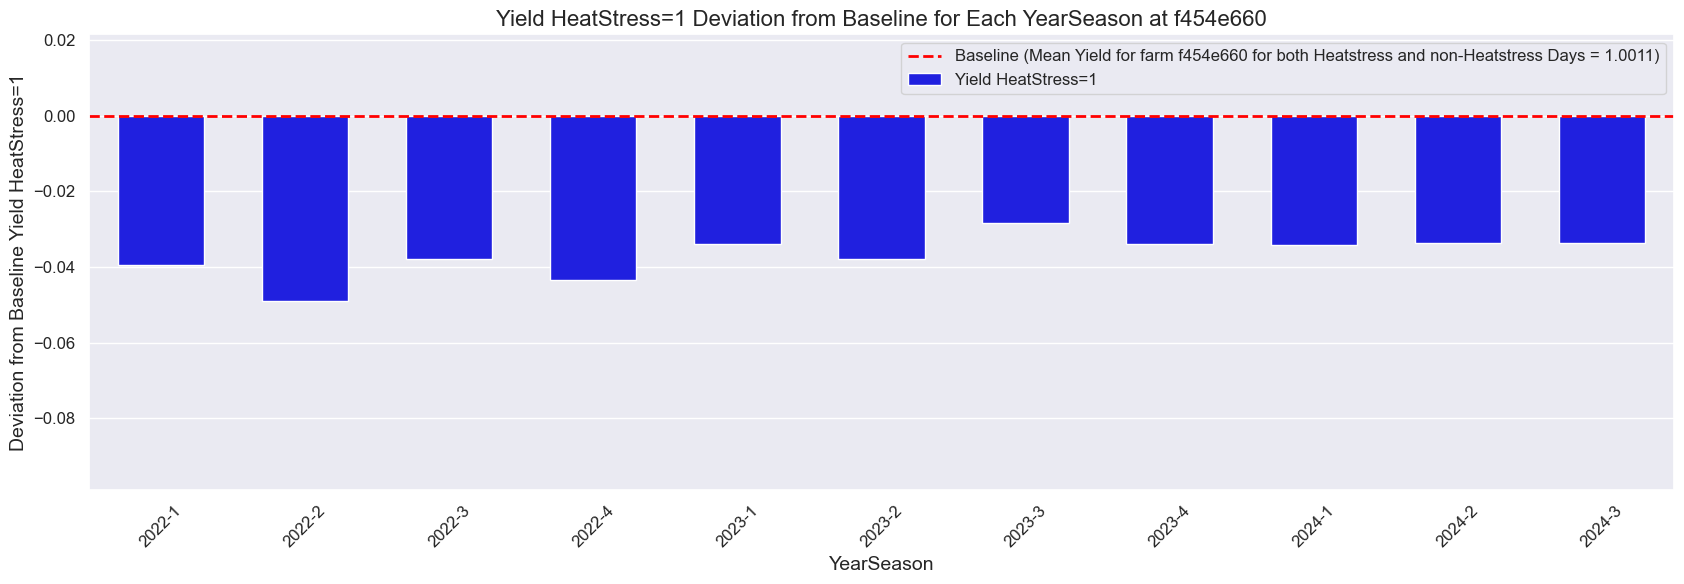

In [13]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.05, max(results_df['Deviation from Baseline HeatStress=1']) + 0.05)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

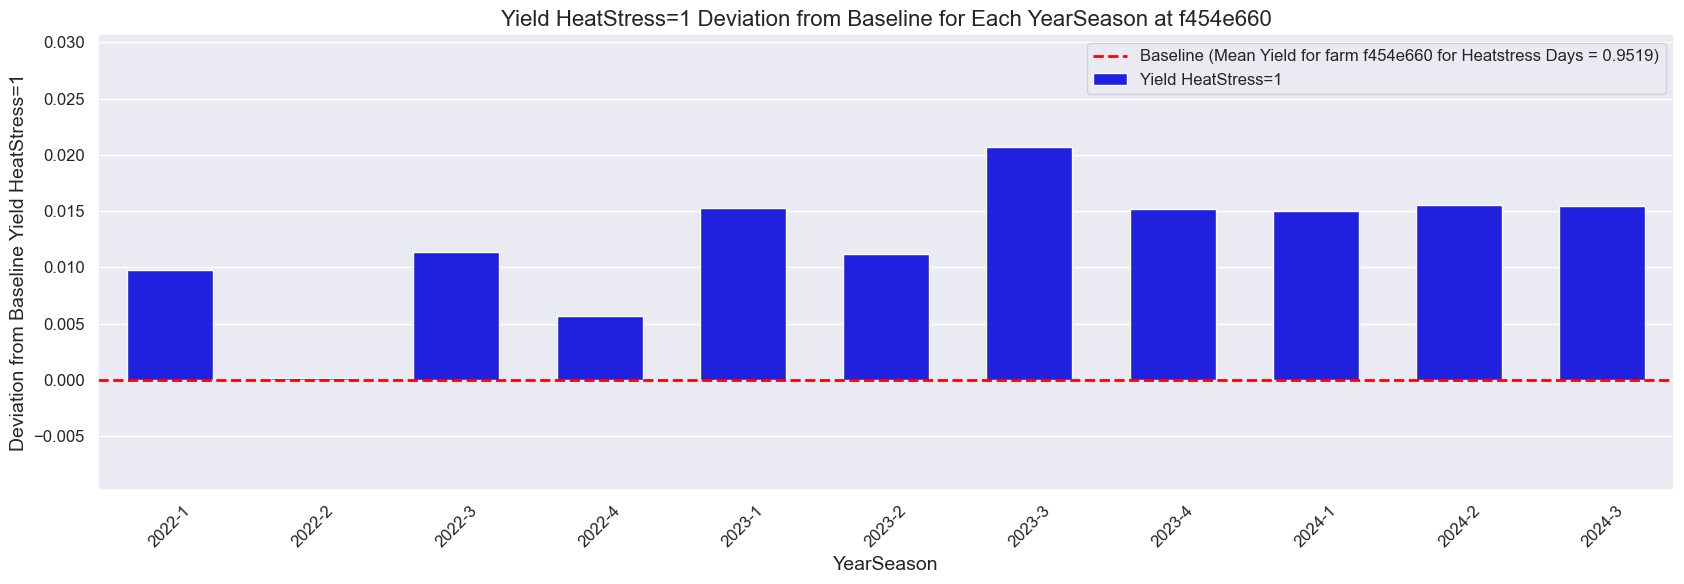

In [14]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()